## Age and Gender Detection System.

### In this project, we will be performing both classification and regression to predict both gender and age respectively.

In [ ]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

## Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !unzip '/content/drive/MyDrive/Projects/CodeClause Projects/Age and Gender Detection System/UTKFace.zip'

In [ ]:
BASE_DIR = '/content/drive/MyDrive/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

In [ ]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

In [58]:
gender_mapping = {
    1: 'Male',
    0: 'Female'
}

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

## Exploratory Data Anlysis

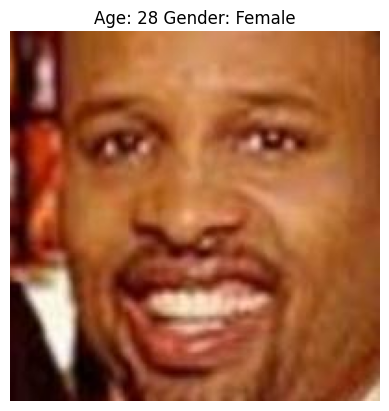

In [59]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

In [ ]:
 # Age distribution
 sns.distplot(df['age'])

The distribution roughly follows a normal distribution that is slightly skewed to the right with a median of around 27 years. The range is from 0 to 120 years. There are some outliers at the higher end of the distribution.

The number of samples for females are slightly higher than that of males. However, the dataset is not highly imbalanced.

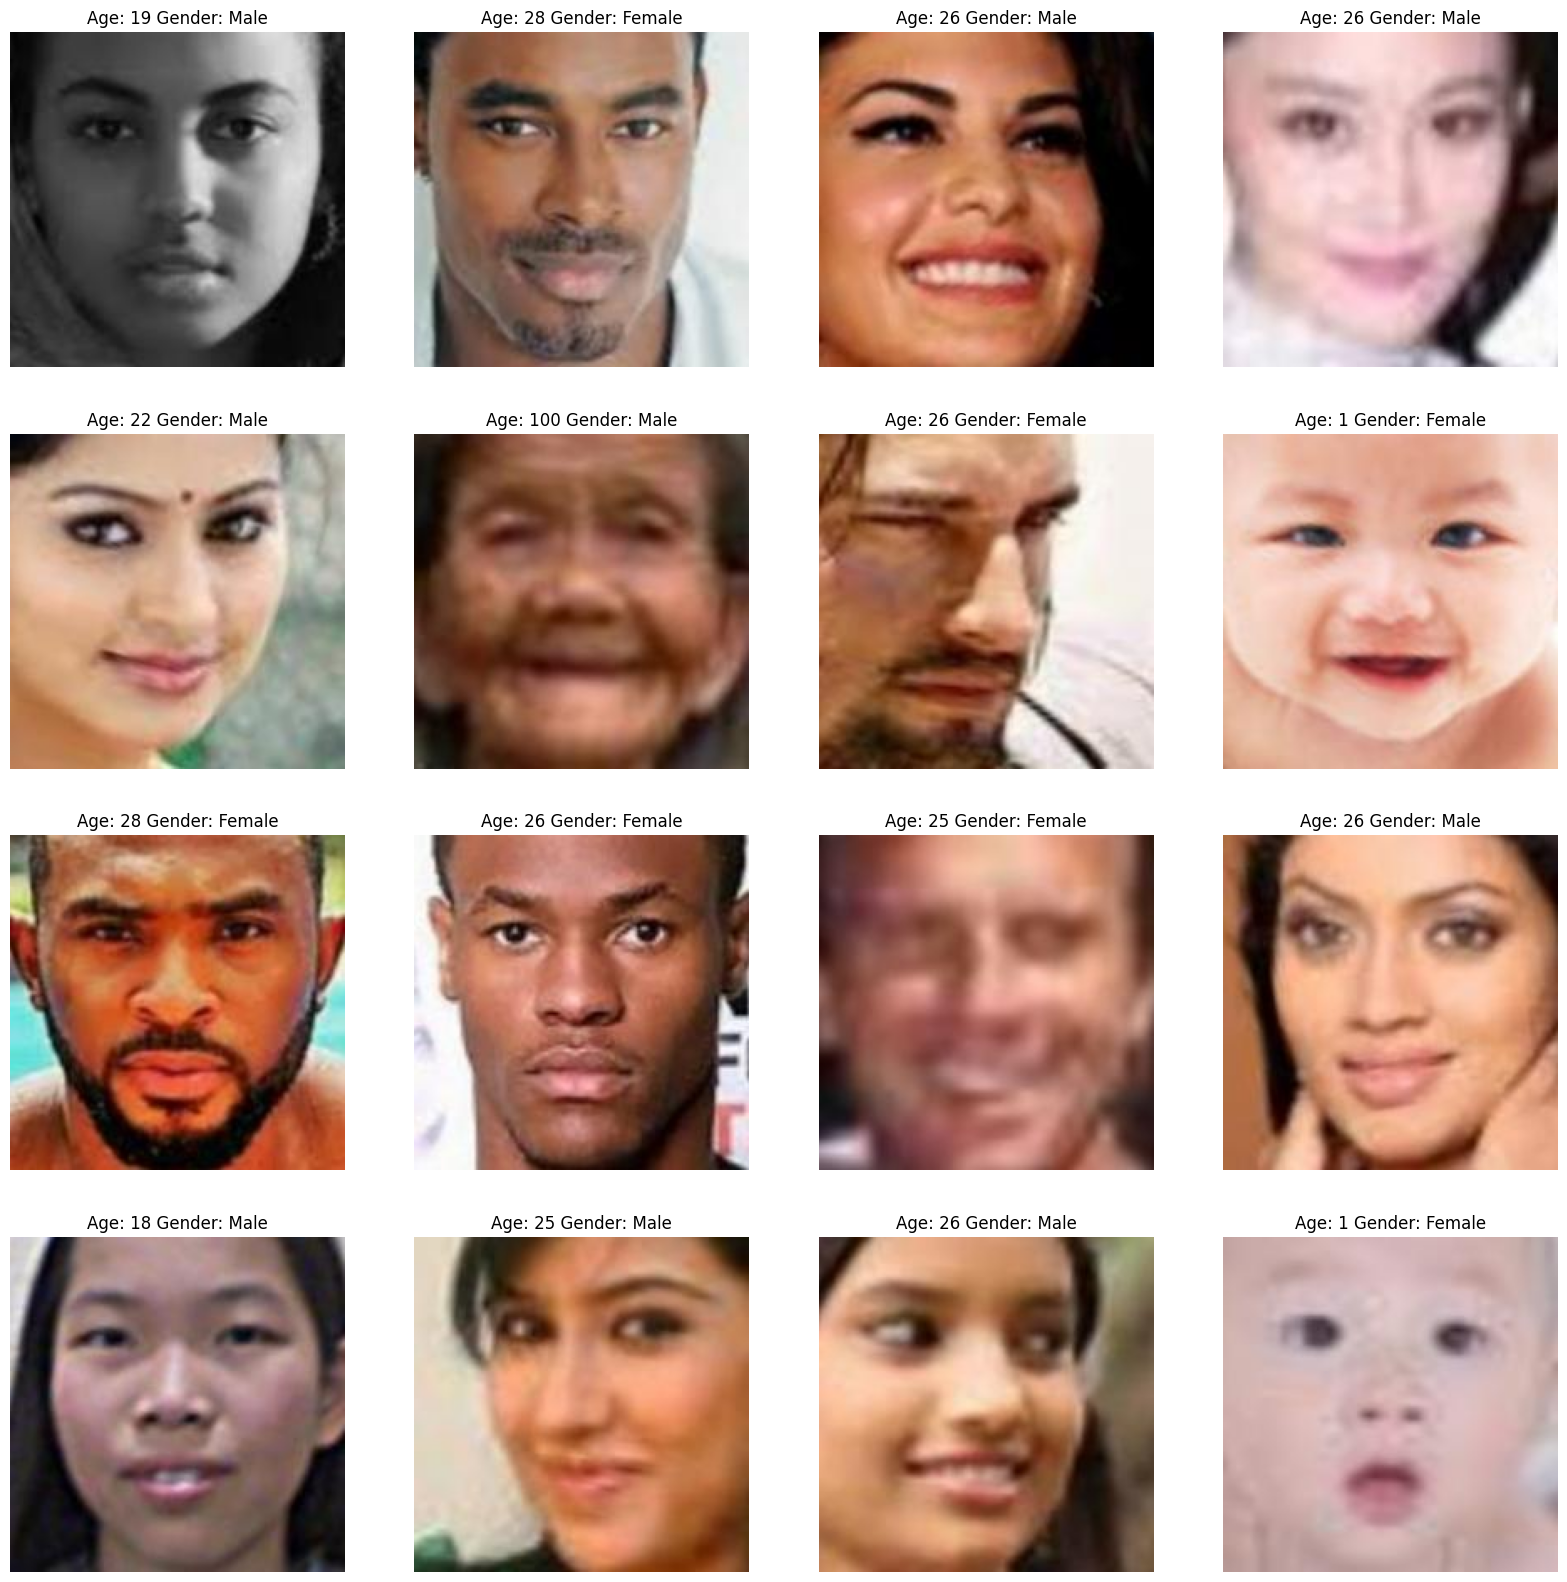

In [60]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

## Feature Extraction

In [ ]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
from PIL import Image

def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image)
        img = img.convert('L')  # Convert to grayscale
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features


In [45]:
X = extract_image_features(df['image_path'])
print(X.shape)


  0%|          | 0/8860 [00:00<?, ?it/s]

(8860, 128, 128, 1)


In [46]:
X = X / 255.0

In [47]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [48]:
input_shape = (128, 128, 1)

In [49]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

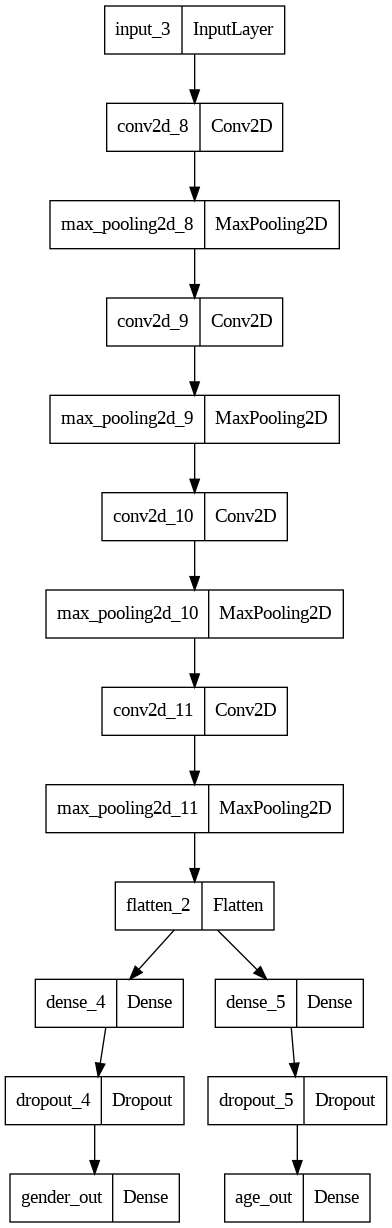

In [50]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [51]:
model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam',
              metrics={'gender_out': 'accuracy', 'age_out': 'mae'})


In [40]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=10, validation_split=0.3)


Epoch 1/10
194/194 [==============================] - 14s 31ms/step - loss: 8.2398 - gender_out_loss: 0.6951 - age_out_loss: 7.5448 - gender_out_accuracy: 0.5401 - age_out_mae: 7.5448 - val_loss: 6.4368 - val_gender_out_loss: 0.6813 - val_age_out_loss: 5.7556 - val_gender_out_accuracy: 0.5591 - val_age_out_mae: 5.7556
Epoch 2/10
194/194 [==============================] - 4s 22ms/step - loss: 6.4678 - gender_out_loss: 0.6538 - age_out_loss: 5.8140 - gender_out_accuracy: 0.6001 - age_out_mae: 5.8140 - val_loss: 5.2420 - val_gender_out_loss: 0.5958 - val_age_out_loss: 4.6462 - val_gender_out_accuracy: 0.6749 - val_age_out_mae: 4.6462
Epoch 3/10
194/194 [==============================] - 4s 23ms/step - loss: 5.3169 - gender_out_loss: 0.5922 - age_out_loss: 4.7247 - gender_out_accuracy: 0.6767 - age_out_mae: 4.7247 - val_loss: 4.5214 - val_gender_out_loss: 0.5338 - val_age_out_loss: 3.9876 - val_gender_out_accuracy: 0.7445 - val_age_out_mae: 3.9876
Epoch 4/10
194/194 [======================

In [41]:
# Save the model
model.save('gender_age_model.keras')


## Plot Results

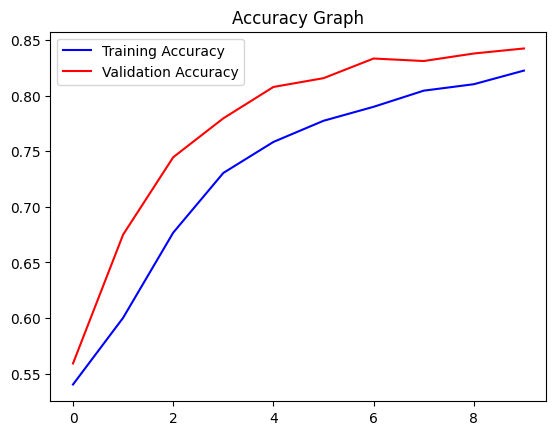

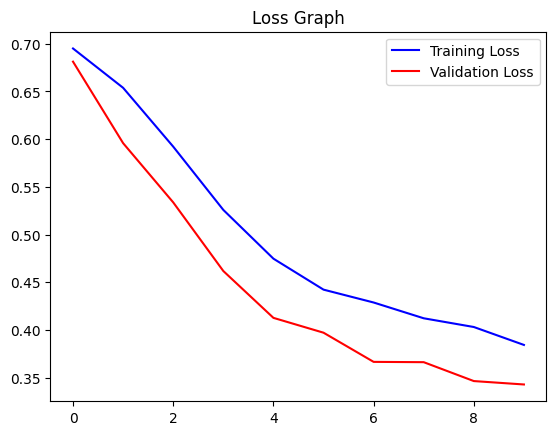

In [42]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [53]:
# model.compile(loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
#               optimizer='adam',
#               metrics={'gender_out': 'accuracy', 'age_out': 'mae'})

# history = model.fit(x=X, y={'gender_out': y_gender, 'age_out': y_age},
#                     batch_size=32, epochs=40, validation_split=0.3)


## Predicting Test Data

In [55]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 [==============================] - 0s 19ms/step


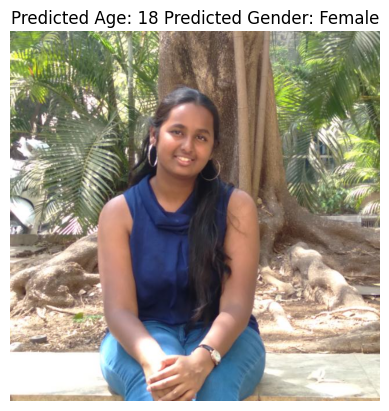

In [61]:
img_to_test = '/content/k.png'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))

<IPython.core.display.Javascript object>

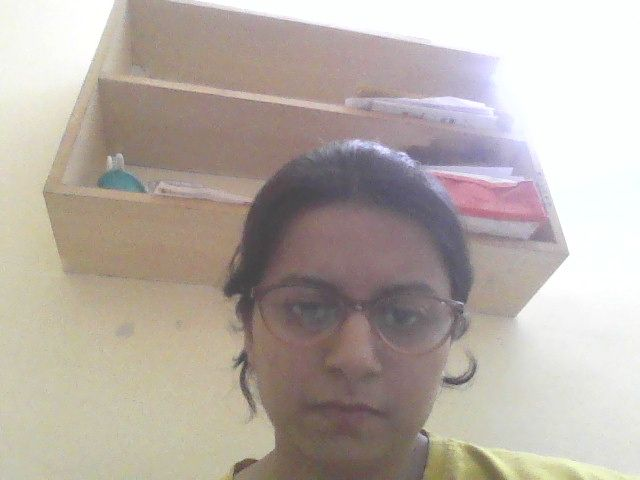

In [62]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capture a photo
image_path = take_photo()

# Display the captured photo
from IPython.display import Image
Image(image_path)


In [64]:
# !pip install --upgrade tensorflow keras

In [1]:
pip install opencv-python

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 90ms/step


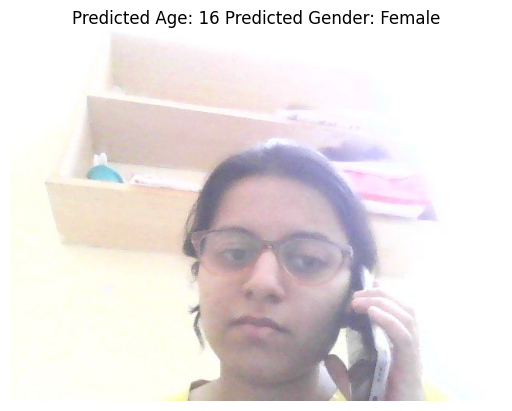

In [3]:
import cv2
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt  # Add this import statement

# Load the pre-trained model
model = load_model('gender_age_model.keras')

# Function to capture an image from the webcam
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture button click
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Capture an image
image_path = take_photo()

# Load the captured image
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))
img = np.array(img)
img = img.reshape(1, 128, 128, 1)
img = img / 255.0

# Predict age and gender
pred_gender, pred_age = model.predict(img)
gender = 'Female' if round(pred_gender[0][0]) == 0 else 'Male'
age = round(pred_age[0][0])

# Display the result
plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.show()


In [4]:
import pickle
pickle.dump(model,open('model.pkl','wb'))